# Adjustment for the G function and light intensity in B and C

The experimental conditions in Caribaño et al. (2025) are quite different. The growth conditions for all experiments have twice the nutrients in the medium and the light intensity is 5 times lower than that used in Nieto et al. (2022).

Since the light effect does not show a lineal relation, and we assume that nutrient media effect does not neither, both parameters will be adjusted. The differential nutrient base will be a scalar for all the G equation. In case of light intensity, it parts in two: $L_c$ and $L_b$.

# 1. Three parameter addition
Equations are redefined as:

### Hipocotile grow model 
From: DOI: 10.1126/sciadv.abp8412

$\frac{dB(t)}{dt}=p_{B}(T)\times L_b\times L(t)\times(mut_{B}-B(t))-k_{r}(T)\times B(t)$

$\frac{dE(t)}{dt}=mut_{E}\times p_{E}\left(t,T,D\right)-d_{E}\times E(t)$

$\frac{dC(t)}{dt}=mut_{C}\left[p_{CL}(T)\times Lc\times L(t)+p_{CD}\bigl(1-L(t)\bigr)\right]-d_{C}\times C(t)$

$\frac{dP(t)}{dt}=mut_{P}\frac{p_{P}}{1+p_{PE}(T)\times E(t)}-\frac{d_{P}}{1+k_{PC}\times C(t)}\times P(t)-d_{PB}\times B(t)\times P(t)$

$\frac{dG(t)}{dt}=\gamma_G \times(p_{G}+k_{G}\frac{p_{GP} P(t)}{1 + p_{GP} P(t) + p_{GE} E(t) + p_{GB} B(t) + H(t)} ); \space H(t)=\dfrac{mut_H\times p_{GH}}{1+p_{HC}\times C(t)}$

ELF3s expression follows a quasi-square wave:

$p_E(t,T,D) = 
\begin{cases} 
p_{E1}(T)+p_{E2}(T), & \text{if } D = 0 \text{ hours},\\[6pt]
p_{E1}(T) - p_{E2}(T) (-1+\dfrac{2}{1+\exp(-k_0 t_0)} - \dfrac{2}{1+\exp(-k_0 t_1)} + \dfrac{2}{1+\exp(-k_0 t_2)}), & \text{if } 0 < D < 24 \text{ hours},\\[8pt]
p_{E1}(T)-p_{E2}(T), & \text{if } D = 24 \text{ hours}.
\end{cases}$


In virtue to reach this fitting, it must only happend in Mock contitions.

### Importing modules:

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import operator

### Loading Data:

In [ ]:
# ==============================
# Load experimental data (bars)
# ==============================
# CSV with MultiIndex (light_condition, ABA_condition, stat)
#   e.g. columns: ['Col','pifq','cop1-4','hy5','PIF4ox','phyB-9']
exp_data = pd.read_csv("experimental_data_for_extended_model.csv", index_col=[0, 1, 2])

# rows: [Low light; Dark]
# strains must match the order below
strains_order = ["Col", "pifq", "cop1-4", "hy5", "35S:PIF4", "phyB-9"]

results_exp = []; stdv_exp = []; 
for light_condition in ["Low light", "Dark"]:
    for_av = []; for_SD = []; 
    
    for strain in strains_order:
        for_av.append(exp_data.loc[(light_condition, "Mock", "Average"), strain])
        for_SD.append(exp_data.loc[(light_condition, "Mock", "SD"), strain])
    results_exp.append(for_av)
    stdv_exp.append(for_SD)

results_exp = np.array(results_exp, dtype=float)  # shape (2, 6): [light, dark] × [6 strains (mock)]
stdv_exp = np.array(stdv_exp, dtype=float)        # shape (2, 6): [light, dark] × [6 strains (mock)]

### Parameters Definition:

In [3]:
# =========================================
# Parameter sets (Nieto et al. 2022 style)
# =========================================
params_by_T = {
    22: dict(
        # ---------- phyB (B) equation ----------
        p_B=10.0,   # pB(22): rate of phyB activation + nuclear import under light at 22°C
        k_r=0.232,  # kr(22): dark-reversion rate of active phyB (Pfr→Pr) at 22°C

        # ---------- ELF3 (E) equation ----------
        p_E1=108.0, # pE1(22): baseline ELF3 production level; together with p_E2 sets average ELF3 synthesis in light and dark at 22°C
        p_E2=39.8,  # pE2(22): amplitude of ELF3 day–night oscillation; p_E1±p_E2 give average ELF3 production in dark (p_E1+p_E2) vs light (p_E1−p_E2)

        # ---------- COP1 (C) equation ----------
        p_CL=1.00,  # pCL(22): COP1 production rate in the light (when L(t)=1) at 22°C

        # ---------- PIFs (P) equation ----------
        p_PE=0.332, # pPE(22): strength of ELF3 repression of PIF transcription at 22°C
    ),

    28: dict(
        # ---------- phyB (B) equation ----------
        p_B=0.86,   # pB(28): rate of phyB activation + nuclear import under light at 28°C
        k_r=0.411,  # kr(28): dark-reversion rate of active phyB at 28°C (faster decay of B at warm temperature)

        # ---------- ELF3 (E) equation ----------
        p_E1=127.0, # pE1(28): baseline ELF3 production level at 28°C
        p_E2=7.29,  # pE2(28): amplitude of ELF3 day–night oscillation at 28°C (smaller oscillation; ELF3 production more similar in light and dark)

        # ---------- COP1 (C) equation ----------
        p_CL=5.37,  # pCL(28): COP1 production rate in the light at 28°C (more COP1 in warm light)

        # ---------- PIFs (P) equation ----------
        p_PE=0.028, # pPE(28): strength of ELF3 repression of PIF transcription at 28°C (very weak repression; EC impaired at warm temperature)
    ),
}

common_params = dict(
    # ================= ELF3 (E) equation =================
    d_E=27.2,   # dE: decay rate of ELF3 protein in the nucleus (temperature-independent)

    # ================= COP1 (C) equation =================
    p_CD=112.0, # pCD: COP1 production rate in the dark (when L(t)=0), independent of T
    d_C=1.79,   # dC: decay/export rate of nuclear COP1

    # ================= PIFs (P) equation =================
    p_P=1.0,    # pP: basal production rate of PIFs (sets overall PIF scale)
    d_P=4.91,   # dP: basal degradation/inactivation rate of PIFs; reduced by COP1
    bd_P=4.91,  # bd_P: alternative PIF degradation parameter for extended conditions (not present in original Nieto model; here kept equal to d_P)
    d_PB=0.313, # dPB: strength of phyB-dependent promotion of PIF degradation/inactivation
    k_PC=34.3,  # kPC: strength of COP1 inhibition of PIF degradation (PIF stabilization)

    # ================ Growth (G) equation =================
    p_G=0.009,  # pG: basal hypocotyl growth rate independent of PIF activity
    k_G=0.113,  # kG: conversion factor from PIF target-gene signal to hypocotyl growth

    p_GP=2.93,  # pGP: weight of PIFs in promoting growth (appears in numerator and denominator of the growth term)

    p_GB=10.7,  # pGB: inhibitory weight of phyB on PIF-driven growth
    p_GE=0.465, # pGE: inhibitory weight of ELF3 on PIF-driven growth

    p_GH=116.0, # pGH: effective contribution of HY5 (growth repressor) to the growthdenominator, after absorbing its basal level
    p_HC=0.180, # pHC: strength of COP1-mediated degradation of HY5 (how strongly COP1 reduces HY5 levels)

    # ===== Extra scaling parameters (model extensions) ==== # -> not part of the original Nieto et al. equation
    gamma_G=1.0,  # global scaling of growth used in the extended (Caribaño et al. 2025) conditions
    Lb=1.0,       # additional light/condition scaling parameter in extended model (not defined in Nieto et al. 2022)
    Lc=1.0        # extra condition-dependent scaling parameter in extended model (not defined in Nieto et al. 2022)
)

# Mutation effects – genotype multipliers (mut_K in the equations)
MUT_B = {
    "WT":1.0,      # wild-type phyB: baseline phyB production
    "phyB-9":0.0,  # phyB-9 null: no functional phyB (B effectively 0)
    "PHYBox":65.0  # PHYB overexpressor: ~65-fold higher phyB production
}

MUT_E = {
    "WT":1.0,      # wild-type ELF3: baseline ELF3 production
    "elf3-8":0.0,  # elf3-8 null: no ELF3 protein (E effectively 0)
    "ELF3ox":1.18  # ELF3 overexpressor line (ELF3ox): 1.18× higher ELF3 production
}

MUT_C = {
    "WT":1.0,      # wild-type COP1: baseline COP1 production
    "cop1-4":0.032,# weak cop1-4 allele: strongly reduced COP1 activity
    "cop1-6":0.056,# cop1-6 hypomorphic allele: temperature-conditional weak COP1
    "COP1-OE":499.0# COP1-OE: very strong COP1 overexpression (~500×)
}

MUT_P = {
    "WT":1.0,      # wild-type PIF complement
    "pif4":0.495,  # pif4 mutant: reduced effective PIF activity
    "pifq":0.198,  # pifq quadruple mutant: very low PIF activity
    "PIF4ox":6.37  # PIF4ox (35S:PIF4-HA): strong PIF4 overexpression
}

MUT_H = {
    "WT":1.0,      # wild-type HY5 levels
    "hy5":0.0      # hy5 loss-of-function: effectively no HY5 contribution to growth
}

# Parameters Backup
BASE_COMMON_PARAMS = common_params.copy()
BASE_MUT_P = MUT_P.copy()


# =========================
# Built Params Dictionary
# =========================
def build_params(T=22, mutB="WT", mutE="WT", mutC="WT", mutP="WT", mutH="WT"):
    if T not in params_by_T:
        raise ValueError("T must be 22 or 28.")
    d = {**common_params, **params_by_T[T]}
    d["T"] = float(T)       # simulation temperature (°C)
    d["mut_B"] = MUT_B[mutB]  # genotype multiplier for phyB
    d["mut_E"] = MUT_E[mutE]  # genotype multiplier for ELF3
    d["mut_C"] = MUT_C[mutC]  # genotype multiplier for COP1
    d["mut_P"] = MUT_P[mutP]  # genotype multiplier for PIFs
    d["mut_H"] = MUT_H[mutH]  # genotype multiplier for HY5
    return d

### Equation system:

In [ ]:
# =========================
# Light function ON/OFF
# =========================
def L_of_t(t, D):
    """
    L(t): 1 during the first D hours of each 24h cycle, else 0.
    """
    return 1.0 if (t % 24) < D else 0.0


# =========================
# ELF3 square-wave p_E(t)
# =========================
def pE_func(t, D, pE1, pE2, k0=5.0):
    '''
    p_E(t): ELF3s production that follows a quasi-square wave function (Nieto et al. 2022).

    Arguments
    ---------
    t      : time (h) – unused except for ODE signature
    D      : (daylength) light hours in the day
    pE1    : ELF3s production level 1
    pE2    : ELF3s production level 2
    k0     : timescale of the rise and fall of the function when changing light conditions, set to 5.0

    Returns
    -------
    Calculus of expresion of ELF3s
    '''
    if D <= 0.0:          # constant dark
        return pE1 + pE2
    elif D >= 24.0:       # constant light
        return pE1 - pE2
    else:
        tau = t % 24; t0 = tau; t1 = t0 - D;  t2 = t0 - 24; 
        return (pE1 - pE2) * (-1 + 2/(1+np.exp(-k0*t0)) - 2/(1+np.exp(-k0*t1)) + 2/(1+np.exp(-k0*t2)))
    

def pE_square(t, D, pE1, pE2):
    '''
    p_E(t): ELF3s production that follows a square wave function.
    '''
    if D <= 0.0:          # constant dark
        return pE1 + pE2
    elif D >= 24.0:       # constant light
        return pE1 - pE2
    else:
        Light = L_of_t(t, D)
        return pE1 + pE2 * (1.0 - 2.0 * Light) # (pE1 - pE2) * L + (pE1 + pE2) * (1.0 - L)

# =========================
# Calibrated ODE model
# =========================
def model_ext(t, y, daylength, params):
    """
    Base (Nieto et al. 2022) extended model WITHOUT any ABA modulation.
    
    Arguments
    ---------
    t      : time (h) – unused except for ODE signature
    y      : [B, E, C, P, G]
    L     : constant light level in [0,1]  (e.g., 0.2 for Low light, 0.0 for Dark)
    params : dict from build_params(...) (keys: p_B,k_r,p_CL,p_CD,p_P,p_PE,d_E,...,mut_B,mut_C,mut_P,mut_E,p_E1,p_E2)

    Returns
    -------
    [dBdt, dEdt, dCdt, dPdt, dGdt]
    """
    # Set parameters
    (p_B,  k_r,  p_CL,  p_CD,  p_P,  p_PE,  d_E,  d_C,  d_P,  k_PC,  d_PB,  p_G,  k_G,  p_GP,  p_GE,  p_GB,  p_GH,  p_HC,  
     mut_B,  mut_C,  mut_P,  mut_E,  mut_H,  p_E1,  p_E2,   gamma_G,  Lb,  Lc) = operator.itemgetter(
    'p_B','k_r','p_CL','p_CD','p_P','p_PE','d_E','d_C','d_P','k_PC','d_PB','p_G','k_G','p_GP','p_GE','p_GB','p_GH','p_HC',
    'mut_B','mut_C','mut_P','mut_E','mut_H','p_E1','p_E2', 'gamma_G','Lb','Lc')(params)
    
    B, E, C, P, G = y

    # Constant-light experiment:
    L = L_of_t(t, D=daylength)

    # ELF3 production
    # p_E = pE_func(t, D=daylength, pE1=p_E1, pE2=p_E2, k0=5.0) * mut_E
    p_E = pE_square(t, D=daylength, pE1=p_E1, pE2=p_E2) * mut_E

    # Core ODEs
    dBdt = p_B * Lb * L * (mut_B - B) - k_r * B
    dEdt = p_E - d_E * E
    dCdt = mut_C * (p_CL * Lc * L + p_CD * (1.0 - L)) - d_C * C
    dPdt = mut_P * (p_P / (1.0 + p_PE * E)) - (d_P / (1.0 + k_PC * C)) * P - d_PB * B * P
    dGdt = p_G + k_G*(p_GP*P) / (1 + p_GP*P + p_GE*E + p_GB*B + mut_H*(p_GH/(1 + p_HC*C))); new_dGdt = gamma_G * dGdt; 

    return [dBdt, dEdt, dCdt, dPdt, new_dGdt]

### Simulations and Plotting:

In [5]:
# =========================
# Simulation wrapper
# =========================
def simulate_experiment(T, daylength, total_days, dt_minutes=240, # 4h
                        mutB="WT", mutE="WT", mutC="WT", mutP="WT", mutH="WT"):
    """Run model_ext and return final G."""
    params = build_params(T=T, mutB=mutB, mutE=mutE, mutC=mutC, mutP=mutP, mutH=mutH)

    dt_h = dt_minutes / 60.0
    total_hours = total_days * 24.0
    n_points = int(round(total_hours / dt_h)) + 1
    t_eval = np.linspace(0.0, total_hours, n_points)

    y0 = [0.0, 0.0, 0.0, 0.0, 0.0]

    sol = solve_ivp(
        fun=lambda t, y: model_ext(t, y, daylength=daylength, params=params),
        t_span=(0.0, total_hours),
        y0=y0,
        method="Radau", # stiff
        t_eval=t_eval,
        rtol=1e-2,
        atol=1e-5,
    )
    if not sol.success:
        raise RuntimeError(sol.message)
    if not np.all(np.isfinite(sol.y)):
        raise RuntimeError("NaN or Inf in solution")

    return float(sol.y[4, -1])   # final G


# =========================
# Model predictions for bars
# =========================

def run_all_simulations(T=22):
    """
    Corre todas las simulaciones con los parámetros ya fijados en common_params.
    Devuelve un array 2x12 como antes:

      rows: [Low light, Dark]
      cols:
        [WT mock, pifq mock, cop1-4 mock, hy5 mock, PIF4ox mock, phyB-9 mock,
         WT ABA,  pifq ABA,  cop1-4 ABA,  hy5 ABA,  PIF4ox ABA,  phyB-9 ABA]
    """
    # results matrix
    res = np.zeros((2, 6), dtype=float)

    # ---- LOW LIGHT (CWL ~ D=16) ----
    res[0, 0] = simulate_experiment(T=T, daylength=16, total_days=5)                 # WT
    res[0, 1] = simulate_experiment(T=T, daylength=16, total_days=5, mutP="pifq")    # pifq
    res[0, 2] = simulate_experiment(T=T, daylength=16, total_days=5, mutC="cop1-4")  # cop1-4
    res[0, 3] = simulate_experiment(T=T, daylength=16, total_days=5, mutH="hy5")     # hy5
    res[0, 4] = simulate_experiment(T=T, daylength=16, total_days=4, mutP="PIF4ox")  # PIF4ox
    res[0, 5] = simulate_experiment(T=T, daylength=16, total_days=4, mutB="phyB-9")  # phyB-9

    # ---- DARK (D=0) ----
    res[1, 0] = simulate_experiment(T=T, daylength=0, total_days=4)                  # WT
    res[1, 1] = simulate_experiment(T=T, daylength=0, total_days=4, mutP="pifq")     # pifq
    res[1, 2] = simulate_experiment(T=T, daylength=0, total_days=4, mutC="cop1-4")   # cop1-4
    res[1, 3] = simulate_experiment(T=T, daylength=0, total_days=4, mutH="hy5")      # hy5
    res[1, 4] = simulate_experiment(T=T, daylength=0, total_days=4, mutP="PIF4ox")   # PIF4ox
    res[1, 5] = simulate_experiment(T=T, daylength=0, total_days=4, mutB="phyB-9")   # phyB-9
    
    return res


def compute_results(T, **params):
    """
    First, actualize the parameters fitting sentitive.

    Returns a 2x6 array with:
      rows: [Low light, Dark]
      cols: [WT, pifq, cop1-4, hy5, PIF4ox, phyB-9] (all Mock)
    
    gamma_G, Lb, Lc are global scalings for growth and light terms.
    """
    # update model params
    for key, value in params.items():
        common_params[key] = float(value)
    
    # run the simulations 
    return run_all_simulations(T)


# =========================
# Plotting function
# =========================

def plot_bars_full(results_exp, stdv_exp, results_fit):
    """
    Bar plot: experimental means + model outlines for
    Low light (row 0) and Dark (row 1), 6 genotypes each.
    """
    labels = [
        "WT, mock", "pifq, mock", "cop1-4, mock",
        "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
    ]
    x = np.arange(1, len(labels) + 1)

    plt.figure(figsize=(12, 8))

    for i, title in enumerate(["growth in Low light", "growth in Dark"], start=1):
        ax = plt.subplot(2, 1, i)

        valid = (
            np.isfinite(results_exp[i - 1, :])
            & np.isfinite(stdv_exp[i - 1, :])
            & (stdv_exp[i - 1, :] > 0)
        )

        if np.any(valid):
            ax.bar(
                x[valid],
                results_exp[i - 1, valid],
                color=(0.7, 0.5, 0.7),
                edgecolor="none",
                label="experimental",
            )
            ax.errorbar(
                x[valid],
                results_exp[i - 1, valid],
                yerr=stdv_exp[i - 1, valid],
                fmt=".",
                color=(0.4, 0.2, 0.4),
                linewidth=1.5,
                capsize=8,
            )

        # model outlines (all bars)
        ax.bar(
            x,
            results_fit[i - 1, :],
            facecolor="none",
            edgecolor="k",
            linewidth=2,
            label="model fit",
        )

        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=15)

        ymax_exp = np.nanmax(results_exp[i - 1, valid]) if np.any(valid) else 0.0
        ymax_mod = np.max(results_fit[i - 1, :])
        base = 4.0 if i == 1 else 16.0
        ymax = max(base, ymax_exp * 1.25, ymax_mod * 1.1)
        ax.set_ylim(0.0, ymax)
        if i == 2:
            ax.set_yticks(range(0, int(np.ceil(ymax)) + 1, 2))

        ax.set_xlim(0.3, len(labels) + 0.7)
        ax.set_ylabel("hypocotyl length (mm)")
        ax.set_title(title)
        if i == 1:
            ax.legend(loc="upper right")
        ax.tick_params(labelsize=11)

    plt.tight_layout()
    plt.show()

# 2. Fitting parameters

## 2.0. Not fitting at all (Base Model VS. Data)

Weighted SSE (using experimental SDs, no fitting): 162.491


Weighted SSE (no fitting): 162.491


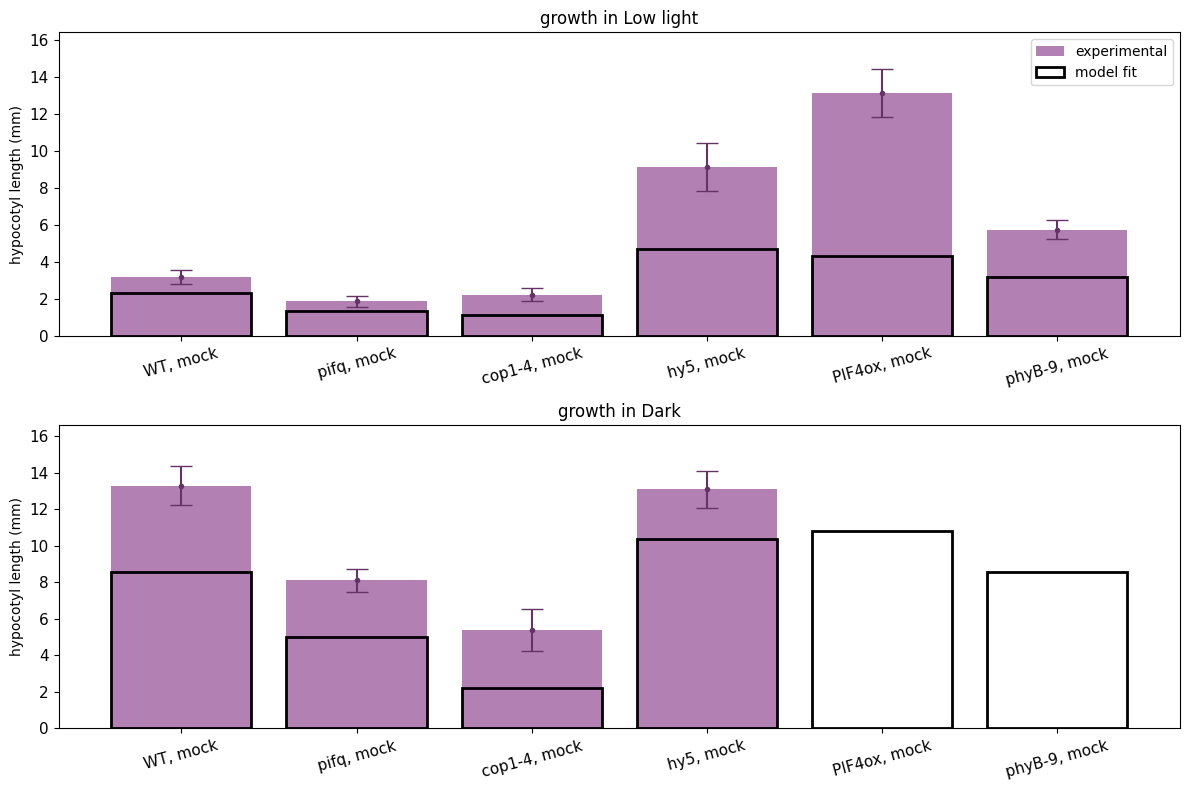


Model (no fit):
            WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light  2.328414    1.372227      1.130112   4.686403      4.300113   
Dark       8.585467    4.991916      2.204199  10.392105     10.824312   

           phyB-9, mock  
Low light      3.165864  
Dark           8.585467  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock  
Low light      5.752222  
Dark                NaN  

Difference (model - exp):
            WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light -0.874836   -0.516939     -1.106588  -4.448497     -8.829512   
Dark      -4.711408   -3.127314     -3.170087  -2.697895           NaN   

           phyB-9, mock  
Low light     -2.586358  
Dark                NaN  


In [6]:
# =========================
# Main: no fitting, just compare
# =========================
if __name__ == "__main__":

    T_fit = 22 

    # Pure model prediction with fixed parameters
    results_fit = compute_results(T_fit)

    # Simple diagnostics of mismatch
    diff = results_fit - results_exp  # model - experiment
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)
    weighted_sse = np.sum(((results_fit - results_exp)[mask] / stdv_exp[mask])**2)

    rows = ["Low light", "Dark"]
    cols = [
        "WT, mock", "pifq, mock", "cop1-4, mock",
        "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
    ]

    # Print results
    print(f"\nWeighted SSE (no fitting): {weighted_sse:.6g}")
    plot_bars_full(results_exp, stdv_exp, results_fit)

    # Tabular printout
    try:
        print("\nModel (no fit):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
        print("\nDifference (model - exp):\n",
              pd.DataFrame(diff, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 2.1. Only gamma_G

Optimized: gamma_G = 1.56108  
Final weighted SSE = 46.4641

Optimization terminated successfully.
         Current function value: 46.464105
         Iterations: 61
         Function evaluations: 152

Optimized: gamma_G = 1.56108
Final weighted SSE = 46.4641


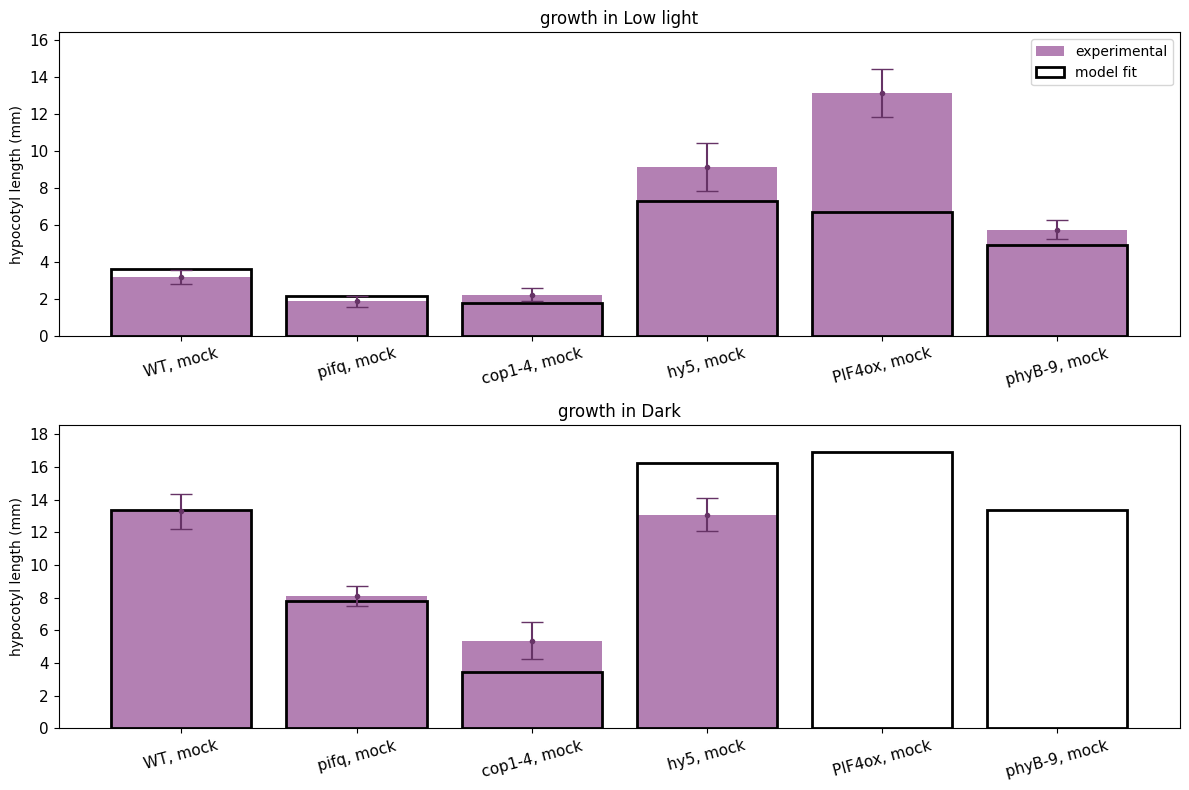


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.634705    2.142144      1.764190   7.315805      6.712828   
Dark       13.402563    7.792758      3.440921  16.222860     16.897566   

           phyB-9, mock  
Low light      4.942792  
Dark          13.402563  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock  
Low light      5.752222  
Dark                NaN  


In [7]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameter:
      gamma_G  (> 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)
        MUT_P.clear();         MUT_P.update(BASE_MUT_P)

        # Apply the adjustment parameter/s
        (log_gamma_G,) = theta

        gamma_G = np.exp(log_gamma_G)

        vec = np.array([gamma_G], dtype=float)

        # Avoid extrem value regimes by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty
        if np.any(vec < 1e-4) or np.any(vec > 200.0):
            return penalty
        if gamma_G < 1.0 or gamma_G > 3.0: 
            return penalty

        try:
            model = compute_results(T=T_fit, gamma_G=gamma_G)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den = stdv_exp[mask]
        resid = diff / den
        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit gamma_G only
# =========================
if __name__ == "__main__":

    T_fit = 22

    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guess: gamma_G ~ 1
    theta0 = [np.log(1.0),]

    res = minimize(objective, theta0,method="Nelder-Mead",
        options=dict(xatol=1e-6, fatol=1e-6, maxiter=800, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    (log_gamma_G_opt,) = res.x
    gamma_G_opt = np.exp(log_gamma_G_opt)

    # Print results
    print(
        f"\nOptimized:"
        f" gamma_G = {gamma_G_opt:.6g}"
    )
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, gamma_G=gamma_G_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)

    # Tabular printout
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 2.2. Fitting gamma_G, Lc, Lb

Optimized: gamma_G = 1.55575, Lb = 0.842716, Lc = 1.04768  
Final weighted SSE = 44.1676

Optimization terminated successfully.
         Current function value: 44.167561
         Iterations: 147
         Function evaluations: 369

Optimized: gamma_G = 1.55575, Lb = 0.842716, Lc = 1.04768
Final weighted SSE = 44.1676


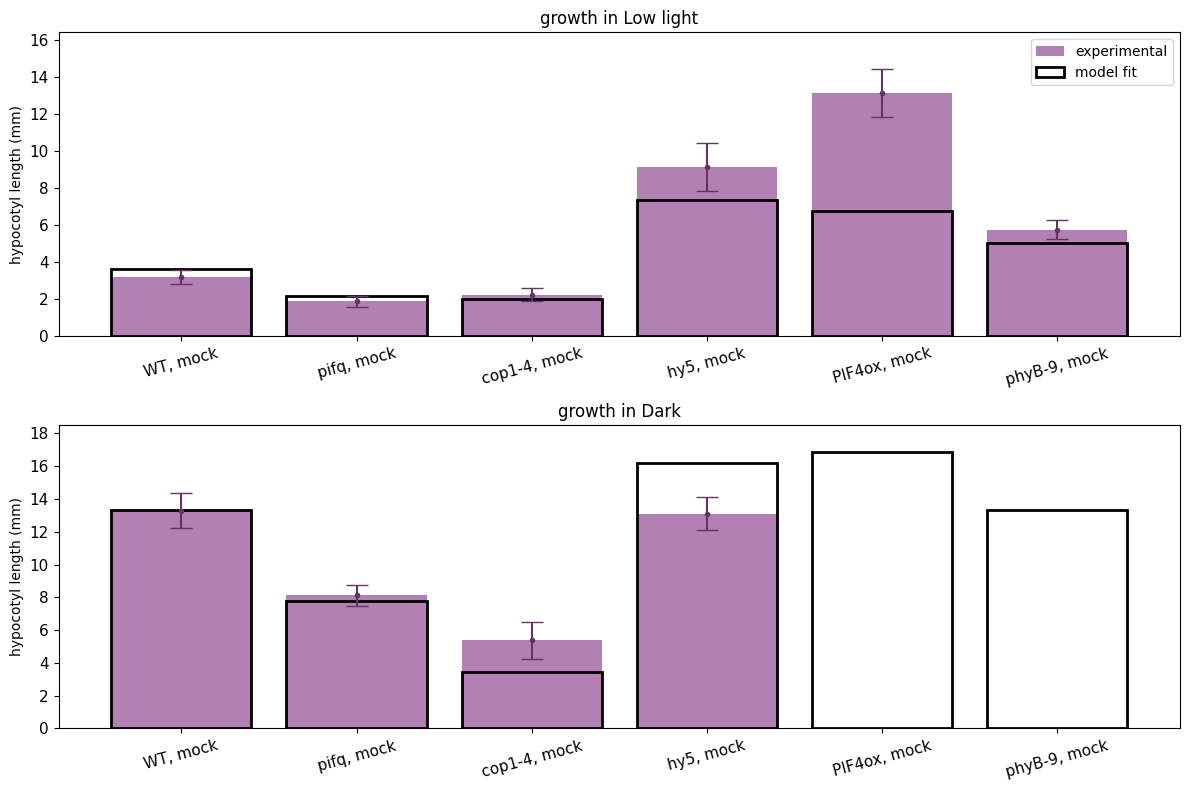


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.643078    2.140096      1.984028   7.361183      6.737641   
Dark       13.356851    7.766180      3.429185  16.167530     16.839934   

           phyB-9, mock  
Low light      5.003191  
Dark          13.356851  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock  
Low light      5.752222  
Dark                NaN  


In [8]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameters:
      gamma_G, Lb, Lc  (all > 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)
        MUT_P.clear();         MUT_P.update(BASE_MUT_P)

        # Apply tying fit parameter/s
        log_gamma_G, log_Lb, log_Lc = theta

        gamma_G = np.exp(log_gamma_G)
        Lb = np.exp(log_Lb)
        Lc = np.exp(log_Lc)

        vec = np.array([gamma_G, Lb, Lc], dtype=float)

        # Avoid extrem value regimes by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty
        if np.any(vec < 1e-4) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, gamma_G=gamma_G, Lb=Lb, Lc=Lc)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den = stdv_exp[mask]
        resid = diff / den
        return float(np.sum(resid * resid))

    return objective

# =========================
# Main: fit gamma_G, Lb, Lc
# =========================
if __name__ == "__main__":

    T_fit = 22

    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guesses: gamma_G ~ 1, Lb ~ 1, Lc ~ 1
    theta0 = [np.log(1.0), np.log(1.0), np.log(1.0),]

    res = minimize(objective, theta0, method="Nelder-Mead",
        options=dict(xatol=1e-6, fatol=1e-6, maxiter=800, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    log_gamma_G_opt, log_Lb_opt, log_Lc_opt = res.x
    gamma_G_opt = np.exp(log_gamma_G_opt)
    Lb_opt = np.exp(log_Lb_opt)
    Lc_opt = np.exp(log_Lc_opt)

    # Print results
    print(
        f"\nOptimized:"
        f" gamma_G = {gamma_G_opt:.6g},"
        f" Lb = {Lb_opt:.6g},"
        f" Lc = {Lc_opt:.6g}"
    )
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, gamma_G=gamma_G_opt, Lb=Lb_opt, Lc=Lc_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 2.3. Gamma and Li

Optimized: gamma_G = 1.50191, Li = 2.05781  
Final weighted SSE = 38.9346

Optimization terminated successfully.
         Current function value: 38.934640
         Iterations: 96
         Function evaluations: 257

Optimized: gamma_G = 1.50191, Li = 2.05781
Final weighted SSE = 38.9346


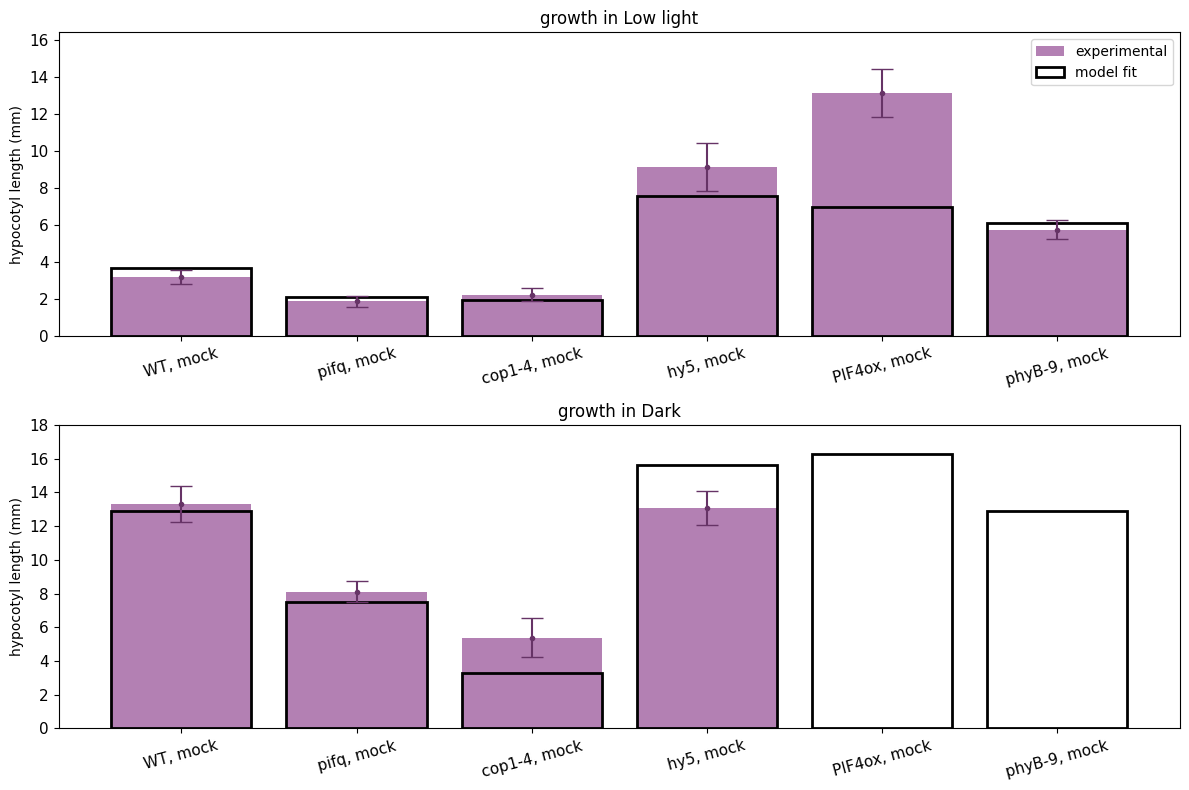


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.683272    2.105340      1.933612   7.558635      6.964181   
Dark       12.894561    7.497387      3.310499  15.607960     16.257092   

           phyB-9, mock  
Low light      6.130343  
Dark          12.894561  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock  
Low light      5.752222  
Dark                NaN  


In [9]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameters:
      gamma_G, Li (both > 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)
        MUT_P.clear();         MUT_P.update(BASE_MUT_P)

        # Apply tying fit parameter/s
        log_gamma_G, log_Li = theta

        gamma_G = np.exp(log_gamma_G)
        Li = np.exp(log_Li)

        vec = np.array([gamma_G, Li], dtype=float)

        # Avoid extrem value regimes by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty
        if np.any(vec < 1e-4) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, gamma_G=gamma_G, Lb=Li, Lc=Li)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den = stdv_exp[mask]
        resid = diff / den
        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit gamma_G, Li
# =========================
if __name__ == "__main__":

    T_fit = 22

    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guesses: gamma_G ~ 1, Li ~ 1
    theta0 = [np.log(1.5), np.log(0.5),]

    res = minimize(objective, theta0, method="Nelder-Mead",
        options=dict(xatol=1e-6, fatol=1e-6, maxiter=800, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    log_gamma_G_opt, log_Li_opt = res.x
    gamma_G_opt = np.exp(log_gamma_G_opt)
    Li_opt = np.exp(log_Li_opt)

    # Print results
    print(
        f"\nOptimized:"
        f" gamma_G = {gamma_G_opt:.6g},"
        f" Li = {Li_opt:.6g}"
    )
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, gamma_G=gamma_G_opt, Lb=Li_opt, Lc=Li_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
   # Tabular printout
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

# 3. ADDing the PIF4ox optimization

Let us do the same, but letting the mut_P for the PIF4ox or 35S:PIF4 as a free parameter to:

In [10]:
original_PIF4ox = MUT_P["PIF4ox"]
original_PIF4ox

6.37

We maintain the equations but we change a little the optimization pipeline. We change the ``compute_results`` to accept mutP_PIF4ox:

In [11]:
def compute_results(T, mutP_PIF4ox, **params):
    """
    First, actualize the parameters fitting sentitive.

    Returns a 2x6 array with:
      rows: [Low light, Dark]
      cols: [WT, pifq, cop1-4, hy5, PIF4ox, phyB-9] (all Mock)
    
    gamma_G, Lb, Lc are global scalings for growth and light terms.
    PIF4ox multiplier is the fixed MUT_P["PIF4ox"].
    """
    # update model params
    for key, value in params.items():
        common_params[key] = float(value)
    
    MUT_P["PIF4ox"] = float(mutP_PIF4ox)

    # run the simulations 
    return run_all_simulations(T)

## 3.1. Gamma and mutP

Optimized: gamma_G = 1.5123, mutP_PIF4ox = 56.2545 vs. original 6.37  
Final weighted SSE = 20.2552

Optimization terminated successfully.
         Current function value: 20.255219
         Iterations: 129
         Function evaluations: 301

Optimized: gamma_G = 1.5123, mutP_PIF4ox = 56.2545 vs. original 6.37
Final weighted SSE = 20.2552


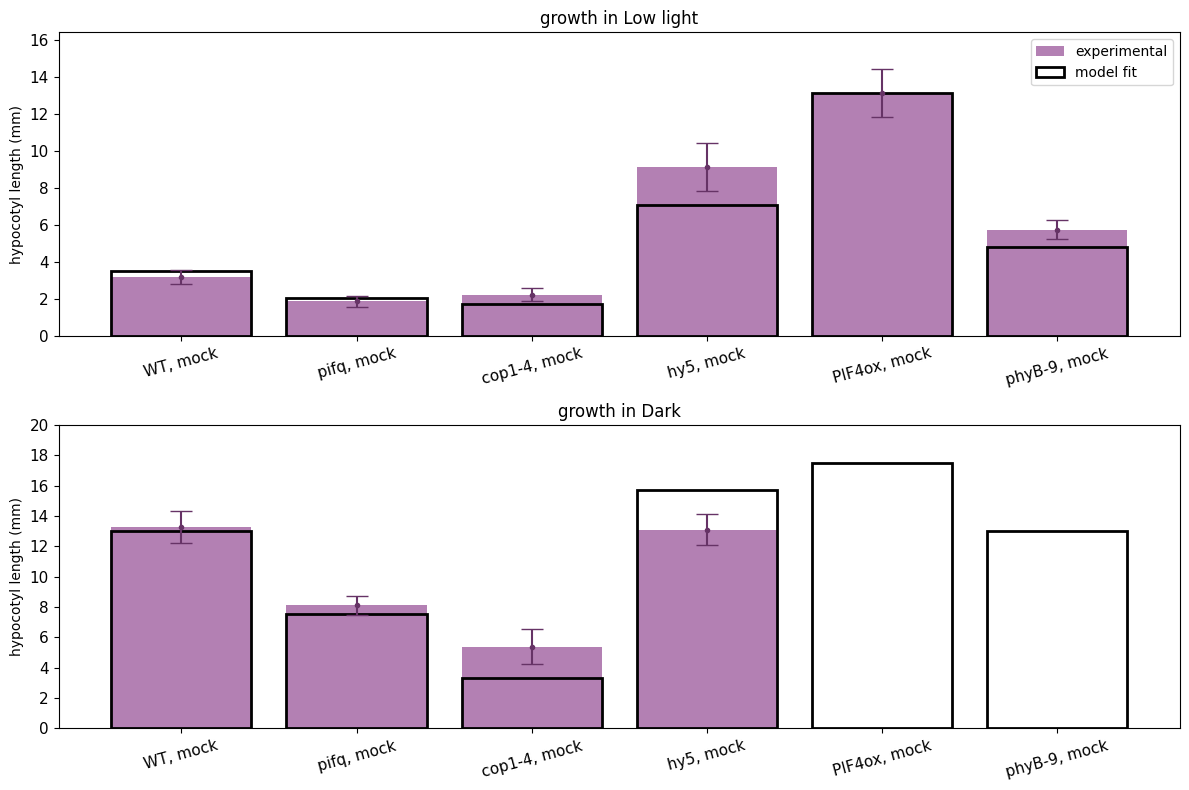


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.521132    2.075226      1.709072   7.087293     13.137538   
Dark       12.983831    7.549292      3.333417  15.716014     17.465512   

           phyB-9, mock  
Low light      4.788393  
Dark          12.983831  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock  
Low light      5.752222  
Dark                NaN  


In [12]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Fitted parameters: gamma_G, mutP_PIF4ox
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)
        MUT_P.clear();         MUT_P.update(BASE_MUT_P)

        # Apply tying fit parameter/s
        log_gamma_G, log_mutP_PIF4ox = theta

        gamma_G = np.exp(log_gamma_G)
        mutP_PIF4ox = np.exp(log_mutP_PIF4ox)

        vec = np.array([gamma_G, mutP_PIF4ox], dtype=float)

        # Avoid extrem value regimes by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty       
        if np.any(vec < 1e-4) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, mutP_PIF4ox=mutP_PIF4ox, gamma_G=gamma_G)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den = stdv_exp[mask]
        resid = diff / den
        return float(np.sum(resid * resid))

    return objective

# =========================
# Main: fit gamma_G, mutP_PIF4ox
# =========================
if __name__ == "__main__":

    T_fit = 22
    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guesses: gamma_G ~ 1, mutP_PIF4ox initial ~ 6.37
    theta0 = [np.log(1.0), np.log(original_PIF4ox),]

    res = minimize(objective, theta0, method="Nelder-Mead",
        options=dict(xatol=1e-6, fatol=1e-6, maxiter=800, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    log_gamma_G_opt, log_mutP_PIF4ox_opt = res.x
    gamma_G_opt = np.exp(log_gamma_G_opt)
    mutP_PIF4ox_opt = np.exp(log_mutP_PIF4ox_opt)

    # Print results
    print(
        f"\nOptimized:"
        f" gamma_G = {gamma_G_opt:.6g},"
        f" mutP_PIF4ox = {mutP_PIF4ox_opt:.6g} vs. original {original_PIF4ox}"
    )
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, mutP_PIF4ox=mutP_PIF4ox_opt, gamma_G=gamma_G_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 3.2. Fitting gamma_G, Lc/Lb and mutP

Optimized: gamma_G = 1.51883, Lb = 0.983897, Lc = 0.724681, mutP_PIF4ox = 62.5603 vs. 6.37  
Final weighted SSE = 24.4675

Optimization terminated successfully.
         Current function value: 24.467524
         Iterations: 251
         Function evaluations: 569

Optimized: gamma_G = 1.51883, Lb = 0.983897, Lc = 0.724681, mutP_PIF4ox = 62.5603 vs. 6.37
Final weighted SSE = 24.4675


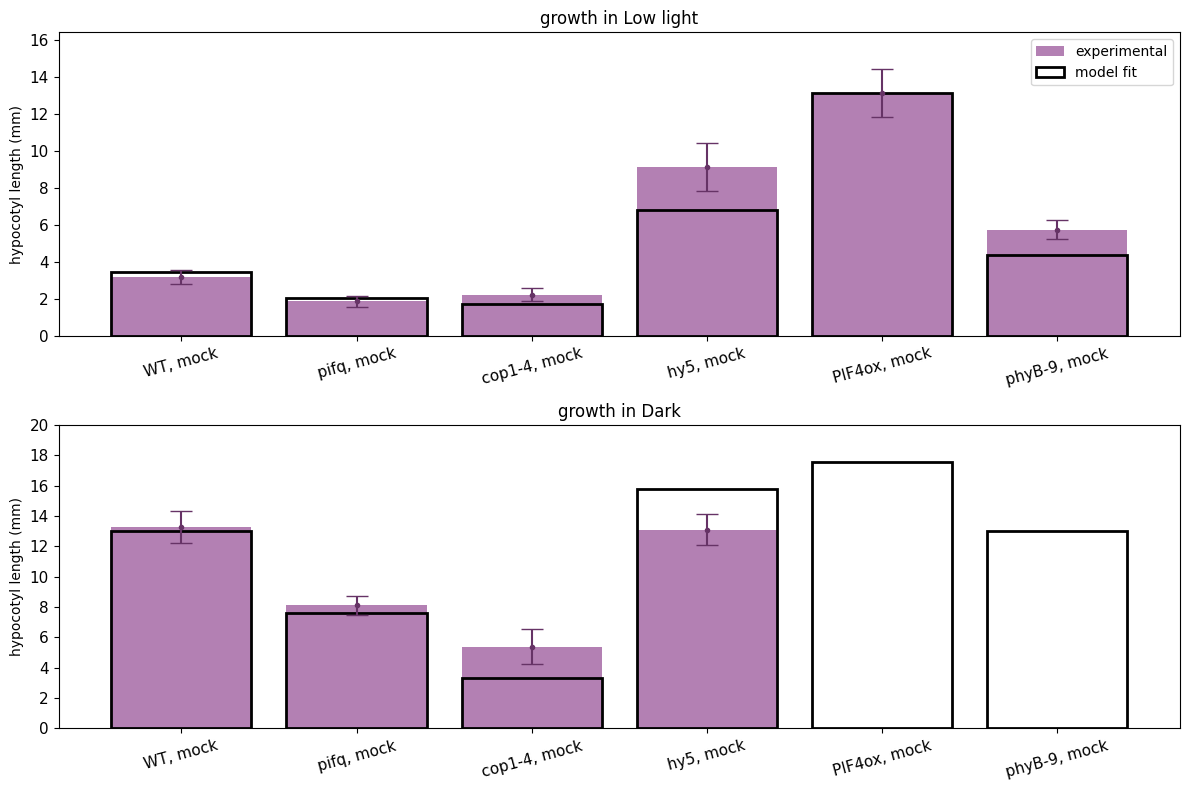


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.444565    2.061923      1.709143   6.814088     13.116383   
Dark       13.039855    7.581867      3.347801  15.783828     17.560842   

           phyB-9, mock  
Low light      4.352121  
Dark          13.039855  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock  
Low light      5.752222  
Dark                NaN  


In [13]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameters:
      gamma_G, Lb, Lc, mutP_PIF4ox  (all > 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)
        MUT_P.clear();         MUT_P.update(BASE_MUT_P)

        # Apply tying fit parameter/s
        log_gamma_G, log_Lb, log_Lc, log_mutP_PIF4ox = theta

        gamma_G = np.exp(log_gamma_G)
        Lb = np.exp(log_Lb)
        Lc = np.exp(log_Lc)
        mutP_PIF4ox = np.exp(log_mutP_PIF4ox)

        vec = np.array([gamma_G, Lb, Lc, mutP_PIF4ox], dtype=float)

        # Avoid extrem value regimes by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty       
        if np.any(vec < 1e-4) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, mutP_PIF4ox=mutP_PIF4ox, gamma_G=gamma_G, Lb=Lb, Lc=Lc)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den = stdv_exp[mask]
        resid = diff / den
        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit gamma_G, Lb, Lc, mutP_PIF4ox
# =========================
if __name__ == "__main__":

    T_fit = 22

    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guesses: gamma_G ~ 1, Lb ~ 1, Lc ~ 1, mutP_PIF4ox ~ 6.37
    theta0 = [np.log(1.0), np.log(1.0), np.log(1.0), np.log(original_PIF4ox),]

    res = minimize(objective, theta0, method="Nelder-Mead",
        options=dict(xatol=1e-6, fatol=1e-6, maxiter=800, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    log_gamma_G_opt, log_Lb_opt, log_Lc_opt, log_mutP_PIF4ox_opt = res.x
    gamma_G_opt = np.exp(log_gamma_G_opt)
    Lb_opt = np.exp(log_Lb_opt)
    Lc_opt = np.exp(log_Lc_opt)
    mutP_PIF4ox_opt = np.exp(log_mutP_PIF4ox_opt)

    # Print results
    print(
        f"\nOptimized:"
        f" gamma_G = {gamma_G_opt:.6g},"
        f" Lb = {Lb_opt:.6g},"
        f" Lc = {Lc_opt:.6g},"
        f" mutP_PIF4ox = {mutP_PIF4ox_opt:.6g} vs. {original_PIF4ox}"
    )
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, mutP_PIF4ox=mutP_PIF4ox_opt, gamma_G=gamma_G_opt, Lb=Lb_opt, Lc=Lc_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 3.3. Fitting gamma_G, Li and mutP

Optimized: gamma_G = 1.51539, Li = 0.824961, mutP_PIF4ox = 60.537 vs. 6.37  
Final weighted SSE = 20.9912

Optimization terminated successfully.
         Current function value: 20.991180
         Iterations: 187
         Function evaluations: 439

Optimized: gamma_G = 1.51539, Li = 0.824961, mutP_PIF4ox = 60.537 vs. 6.37
Final weighted SSE = 20.9912


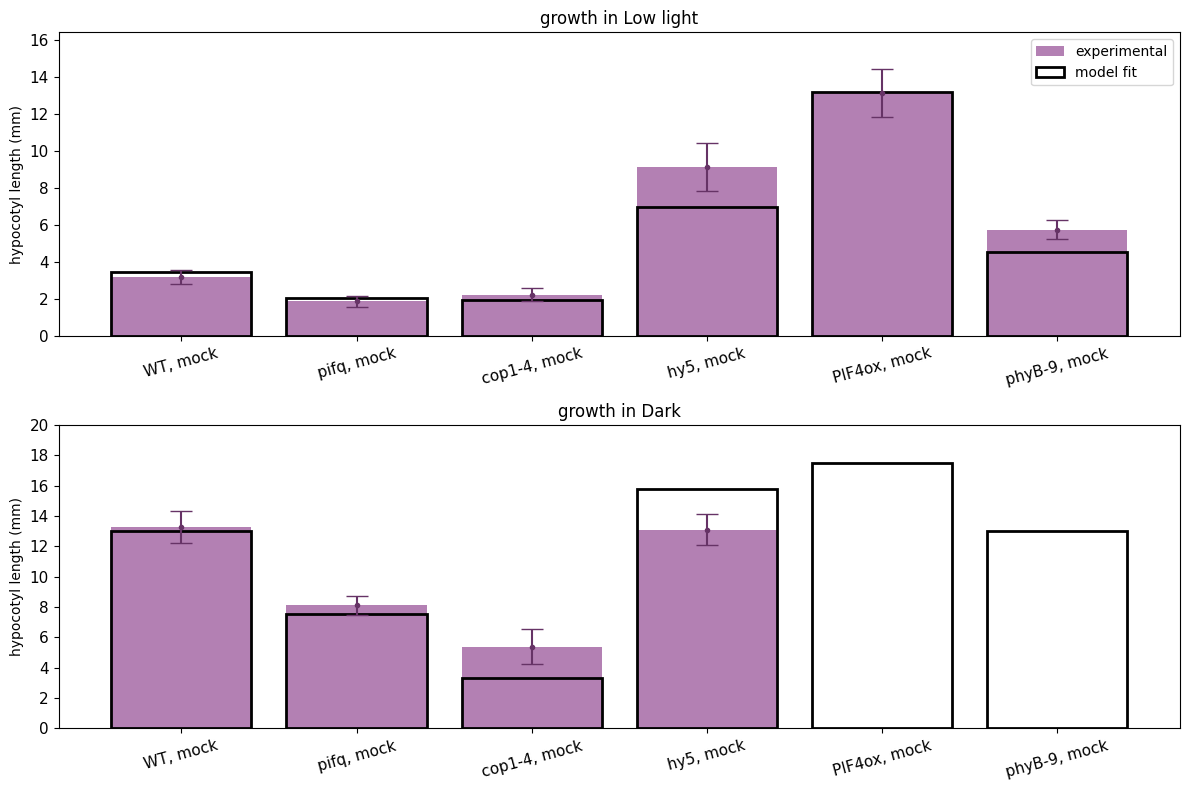


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.480145    2.067952      1.927901   6.949088     13.160274   
Dark       13.010329    7.564699      3.340220  15.748088     17.515092   

           phyB-9, mock  
Low light      4.513120  
Dark          13.010329  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock  
Low light      5.752222  
Dark                NaN  


In [23]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameters:
      gamma_G, Li, mutP_PIF4ox  (all > 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)
        MUT_P.clear();         MUT_P.update(BASE_MUT_P)

        # Apply tying fit parameter/s
        log_gamma_G, log_Li, log_mutP_PIF4ox = theta

        gamma_G = np.exp(log_gamma_G)
        Li = np.exp(log_Li)
        mutP_PIF4ox = np.exp(log_mutP_PIF4ox)

        vec = np.array([gamma_G, Li, mutP_PIF4ox], dtype=float)

        # Avoid extrem value regimes by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty       
        if np.any(vec < 1e-3) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, mutP_PIF4ox=mutP_PIF4ox, gamma_G=gamma_G, Lb=Li, Lc=Li)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den = stdv_exp[mask]
        resid = diff / den
        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit gamma_G, Li, mutP_PIF4ox
# =========================
if __name__ == "__main__":

    T_fit = 22

    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guesses: gamma_G ~ 1, Li ~ 1, mutP_PIF4ox ~ 6.37
    theta0 = [np.log(1.0), np.log(1.0), np.log(MUT_P['PIF4ox']),]

    res = minimize(objective, theta0, method="Nelder-Mead",
        options=dict(xatol=1e-3, fatol=1e-3, maxiter=400, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    log_gamma_G_opt, log_Li_opt, log_mutP_PIF4ox_opt = res.x
    gamma_G_opt = np.exp(log_gamma_G_opt)
    Li_opt = np.exp(log_Li_opt)
    mutP_PIF4ox_opt = np.exp(log_mutP_PIF4ox_opt)

    # Print results
    print(f"\nOptimized: gamma_G = {gamma_G_opt:.6g}, Li = {Li_opt:.6g}, "
        f"mutP_PIF4ox = {mutP_PIF4ox_opt:.6g} vs. {original_PIF4ox}")
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, mutP_PIF4ox=mutP_PIF4ox_opt, gamma_G=gamma_G_opt, Lb=Li_opt, Lc=Li_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)